In [28]:
import urllib
import json
import coremltools as ct

import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
import torch.optim as optim

import numpy as np
from PIL import Image
import glob

from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import U2NET # full size version 173.6 MB

### Load model

In [5]:
# --------- 1. get image path and name ---------
model_name='u2net'#u2netp



image_dir = os.path.join(os.getcwd(), 'test_data', 'test_images')
prediction_dir = os.path.join(os.getcwd(), 'test_data', model_name + '_results' + os.sep)
model_dir = os.path.join(os.getcwd(), 'saved_models', model_name, model_name + '.pth')

img_name_list = glob.glob(image_dir + os.sep + '*')
print(img_name_list)

# --------- 2. dataloader ---------
#1. dataloader
test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                    lbl_name_list = [],
                                    transform=transforms.Compose([RescaleT(320),
                                                                  ToTensorLab(flag=0)])
                                    )
test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                    batch_size=1,
                                    shuffle=False,
                                    num_workers=1)

# --------- 3. model define ---------
if(model_name=='u2net'):
    print("...load U2NET---173.6 MB")
    net = U2NET(3,1)
elif(model_name=='u2netp'):
    print("...load U2NEP---4.7 MB")
    net = U2NETP(3,1)

if torch.cuda.is_available():
    net.load_state_dict(torch.load(model_dir))
    net.cuda()
else:
    net.load_state_dict(torch.load(model_dir, map_location='cpu'))
net.eval()

['/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/horse.jpg', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/boat.jpg', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/0002-01.jpg', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/im_21.png', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/bike.jpg', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/girl.png', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/im_27.png', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/whisk.png', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/0003.jpg', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/lamp2_meitu_1.jpg', '/Users/jbenavidesv/Google Drive/deep-learning/U-2-Net/test_data/test_images/vangogh.jpeg', '/Users/jbe

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

### Load test image

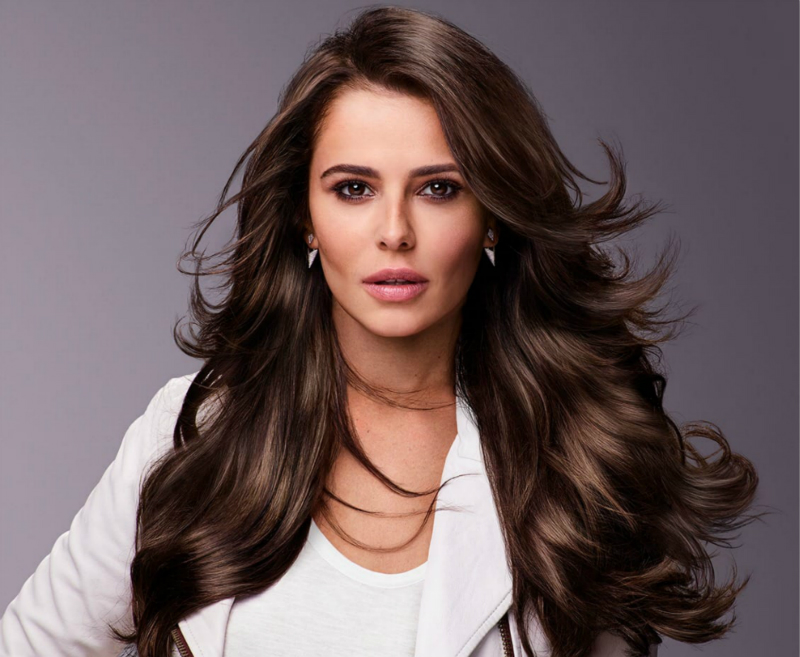

In [20]:
input_image = Image.open('test_data/test_images/0002-01.jpg')
display(input_image)

### Image Preprocessing


In [25]:
to_tensor = transforms.ToTensor()
input_tensor = to_tensor(input_image)
input_batch = input_tensor.unsqueeze(0)
# First attempt at tracing
trace = torch.jit.trace(net, input_batch)

In [35]:
inputs=[ct.ImageType(name="input_1", shape=input_batch.shape)]

model = ct.convert(
    trace,
    inputs=inputs, #name "input_1" is used in 'quickstart'
)

TypeError: Unsupported numpy type: float32

### Scripted Model with PyTorch

In [43]:
#model = ControlFlowNet(num_channels=3)
#inputs_2=ct.ImageType(name="input_1", shape=input_batch.shape)
inputs_2 = ct.TensorType(shape=input_tensor.shape)
print(inputs_2)
scripted_model = torch.jit.script(net)

mlmodel = ct.converters.convert(
  scripted_model,
  inputs=[inputs_2],
)

TensorType[name=None, shape=<coremltools.converters.mil.input_types.Shape object at 0x7f9766907f10>, dtype=<class 'coremltools.converters.mil.mil.types.type_double.make_float.<locals>.double'>]


RuntimeError: 
temporary: the only valid use of a module is looking up an attribute but found  = prim::SetAttr[name="num_batches_tracked"](%42136, %42474)
:


### Convert to Core ML

In [17]:
# Define input
scripted_model = torch.jit.script(net)
